<a href="https://colab.research.google.com/github/ziatdinovmax/OpticalNanoImagingML/blob/main/OpticalNanoSpectroscopy_Decomposition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decomposition ML analysis of optical nanospectroscopy data


- Notebook prepared by Maxim Ziatdinov
- Data from Patrick El-Khoury
- Last notebook revision on Dec 8th, 2023

This notebook demonstrates application of basic decomposition ML tools to hyperspectral data from optical nanospectroscopy measurements. Make sure to load the decomposition methods below (click on "play" button in the next notebook cell). You may also click on "Show code" to study them in more details.

In [ ]:
# @title Load Decomposition methods { display-mode: "form" }

import numpy as np
import warnings
from sklearn import decomposition, mixture
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

class Decomposition:
    """
    The Decomposition class provides methods for performing various statistical
    and mathematical decomposition analyses on hyperspectral data.
    """

    def __init__(self, hyperdata):
        """
        Initializes the Decomposition object with the provided hyperspectral data.
        The data is expected to be a 3D array with dimensions corresponding to height (h), width (w), and spectral bands (e).

        Parameters:
        - hyperdata: numpy array with the shape (height, width, spectral bands)
        """
        h, w, e = hyperdata.shape
        self.h = h  # Storing the original dimensions
        self.w = w
        self.e = e
        self.hdata = hyperdata.reshape(h*w, e).T

    def pca(self, n_components, plot_results=True, sync_spectra_y_axis=False, **kwargs):
        """
        Performs Principal Component Analysis (PCA) on the hyperspectral data.
        Reduces the data to the specified number of principal components.
        Optionally plots the results with the spectral components and their corresponding spatial distributions.
        """
        pca = decomposition.PCA(n_components=n_components, **kwargs)
        spectral_components = pca.fit_transform(self.hdata).T
        maps = pca.components_
        maps = maps.reshape(n_components, self.h, self.w)
        if plot_results:
            self.plot_decomposition_results(maps, spectral_components, sync_spectra_y_axis)
        return maps, spectral_components

    def nmf(self, n_components, plot_results=True, sync_spectra_y_axis=False, **kwargs):
        """
        Applies Non-negative Matrix Factorization (NMF) to the hyperspectral data.
        Decomposes the data into non-negative components and basis vectors.
        If the data contains negative values, it is normalized first.
        Optionally plots the results with the components and their corresponding spatial distributions.
        """
        if np.any(self.hdata < 0):
            warnings.warn("NMF requires non-negative input data. Data will be normalized to [0, 1].")
            data = (self.hdata - np.min(self.hdata)) / (np.max(self.hdata) - np.min(self.hdata))
        else:
            data = self.hdata

        nmf = decomposition.NMF(n_components=n_components, max_iter=10000, **kwargs)
        spectral_components = nmf.fit_transform(data).T
        maps = nmf.components_
        maps = maps.reshape(n_components, self.h, self.w)
        if plot_results:
            self.plot_decomposition_results(maps, spectral_components, sync_spectra_y_axis)
        return maps, spectral_components

    def ica(self, n_components, plot_results=True, sync_spectra_y_axis=False, **kwargs):
        """
        Conducts Independent Component Analysis (ICA) on the hyperspectral data.
        Separates the data into statistically independent components.
        Optionally plots the results with the components and their corresponding spatial distributions.
        """
        ica = decomposition.FastICA(n_components=n_components, **kwargs)
        spectral_components = ica.fit_transform(self.hdata).T
        maps = ica.components_
        maps = maps.reshape(n_components, self.h, self.w)
        if plot_results:
            self.plot_decomposition_results(maps, spectral_components, sync_spectra_y_axis)
        return maps, spectral_components

    def gmm(self, n_components, covariance = 'diag',
            plot_results=True, sync_spectra_y_axis=False, **kwargs):
        """
        Uses a Gaussian Mixture Model (GMM) to cluster the hyperspectral data into a specified number of classes.
        Determines the spatial distribution of each class and computes the mean spectra.
        Optionally plots the classification results.
        """
        clf = mixture.GaussianMixture(
            n_components=n_components, covariance_type=covariance, **kwargs)
        classes = clf.fit_predict(self.hdata.T)

        image = classes.reshape(self.h, self.w)
        class_indices = np.arange(n_components).reshape(-1, 1, 1)
        maps = (image == class_indices)
        maps = maps.astype(np.uint8)

        spectral_components = np.zeros((n_components, self.e))
        for i in range(n_components):
            cl = self.hdata[:, classes == i]
            spectral_components[i] = np.mean(cl, axis=1)

        if plot_results:
            self.plot_decomposition_results(maps, spectral_components, sync_spectra_y_axis)

        return maps, spectral_components

    def plot_decomposition_results(self, maps, spectra, uniform_y_axis=False):
        """
        Utility method to plot the results of a decomposition analysis.
        """
        nc = maps.shape[0]
        per_row = 5  # Maximum number of plots per row
        total_rows = (nc // per_row) * 2 + (2 if nc % per_row else 0)
        cols = per_row

        if uniform_y_axis:
            y_min = np.min([np.min(spectra[i]) for i in range(nc)])
            y_max = np.max([np.max(spectra[i]) for i in range(nc)])

        fig = plt.figure(figsize=(4*cols, 4*total_rows), constrained_layout=True)
        gs = gridspec.GridSpec(total_rows, cols, figure=fig)

        for i in range(nc):
            row = (i // per_row) * 2
            col = i % per_row

            spec_ax = fig.add_subplot(gs[row, col])  # First row, same column
            spec_ax.plot(spectra[i])
            if uniform_y_axis:
                spec_ax.set_ylim([y_min, y_max])
            spec_ax.set_title('Spectral component {}'.format(i+1))

            map_ax = fig.add_subplot(gs[row + 1, col])  # Next row, same column
            map_ax.imshow(maps[i], cmap='seismic', interpolation='nearest')
            map_ax.set_aspect('equal')
            map_ax.axis('off')
            map_ax.set_title('Map {}'.format(i+1))

        plt.show()

## Load data


First, we load data into the notebook. We use [NumPy's](https://en.wikipedia.org/wiki/NumPy) ```genfromtxt``` to convert a csv file into a format understandable by machine learning methods in Python.

In [ ]:
data1 = np.genfromtxt('/content/s024-nearfield-3D.csv', delimiter=',', dtype=None, encoding=None)

Let's check the dimensionality ("shape") of the data:

In [ ]:
data1.shape

(2501, 1602)

Based on the accompanying .gwy files it appears that the correct data shape is 50x50x1600, where the first two dimensions are image height and width and the third one is a number of spectral bands. Because of the way it was saved, the spatial dimensions were flattened into 50x50 = 3000. There are also additional non-numerical entries asociated with saved column labels. Hence, we are going to remove those entries.

In [ ]:
hdata1 = data1[1:, 2:]

Let's first check for the outliers that may skew the analysis. Here we treat very large negative values as outliers. First, we identify the spectra that have them.

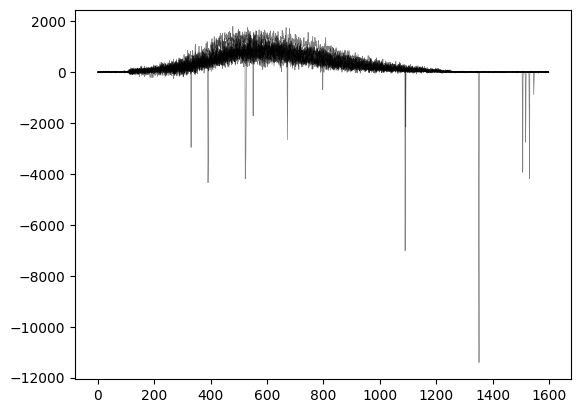

In [ ]:
outliers = hdata1 < -500

outlier_indices, _ = np.where(outliers)
outlier_indices = np.unique(outlier_indices)

for idx in outlier_indices:
    plt.plot(hdata1[idx], lw=.5, alpha=0.5, c='k')

Next, we replace those outliers with the median value of spectrum where they were detected.

In [ ]:
for idx in outlier_indices:
    # Calculate the median of the non-outlier values in this spectrum
    spectrum_median = np.median(hdata1[idx, ~outliers[idx]])

    # Replace outliers in this spectrum with the spectrum-specific median
    hdata1[idx, outliers[idx]] = spectrum_median

Plot the same spectra after the outlier removal:

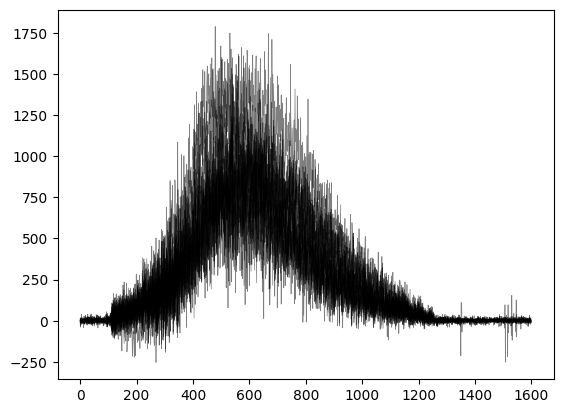

In [ ]:
for idx in outlier_indices:
    plt.plot(hdata1[idx], lw=.5, alpha=0.5, c='k')

Let's visualize several selected spectral bands for a sanity check. The image may appear transposed compared to a different visualization software - don't worry about it as it won't affect the analysis.

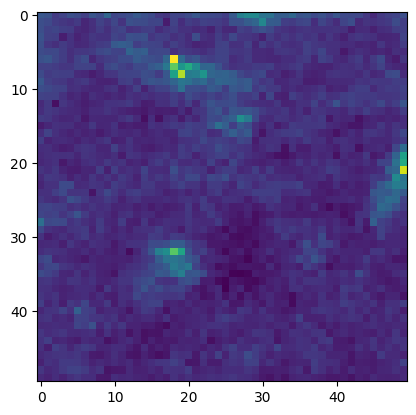

In [ ]:
band = 800

hdata1 = hdata1.reshape(50, 50, 1600)

plt.imshow(hdata1[..., band])

Let's also extract the start and end wavenumber values and convert them to energies for plotting purposes:

In [ ]:
wv_start = data1[0, 2]
wv_end = data1[0, -1]

energies = 1239.8  / np.linspace(wv_start, wv_end, hdata1.shape[-1])

Normalize data to [0, 1] range. This step is not required, but is highly recommended for better perfomance of ML tools.

In [ ]:
hdata1 = (hdata1 - hdata1.min()) / hdata1.ptp()

Here we use a non-negative matrix factorization (NMF). NMF decomposes the hyperspectral data into components that can be understood as 'parts' of the original data. Each component in the decomposition typically represents a distinct spectral signature of an 'object' present within the field of view.




We will need to specify a number of NMF components. There are several fancy techniques for this, but in practice the easiest way is do this is to start with a number corresponding to the number of major modes in the system (the types of expected physical excitations) and then do under- and over-sampling. In this example, we simply perform analysis for the number of components in a range between 2 and 5.

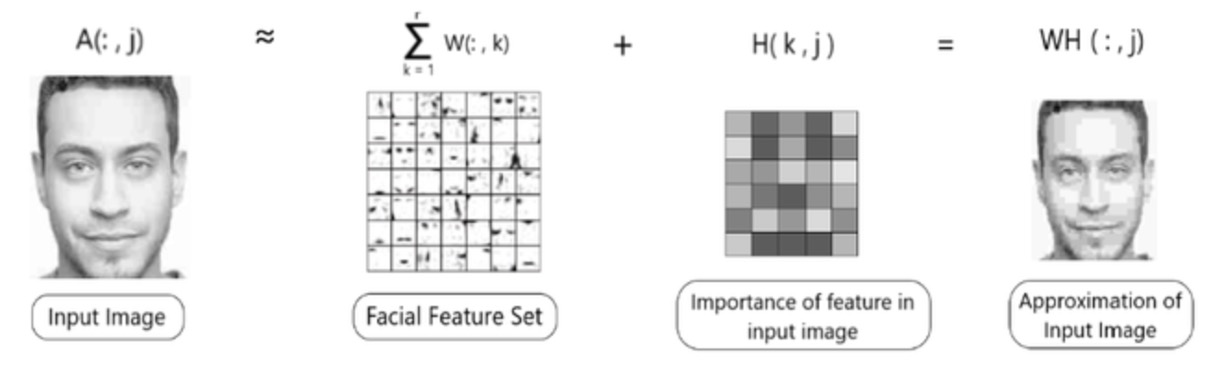

Let's run NMF:

NUMBER OF COMPONENTS: 2


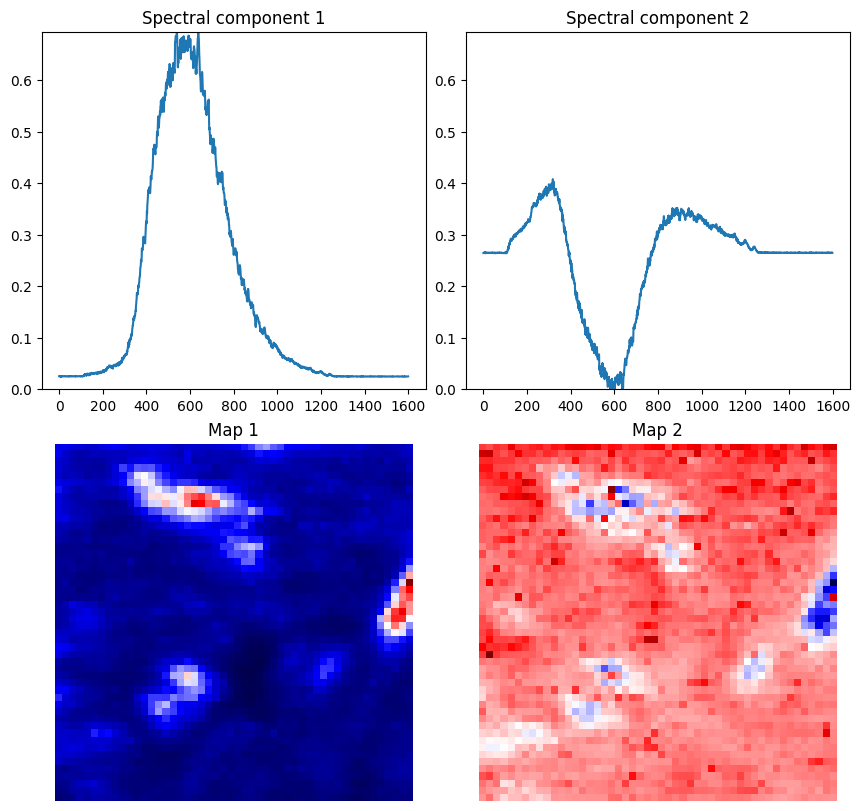

NUMBER OF COMPONENTS: 3


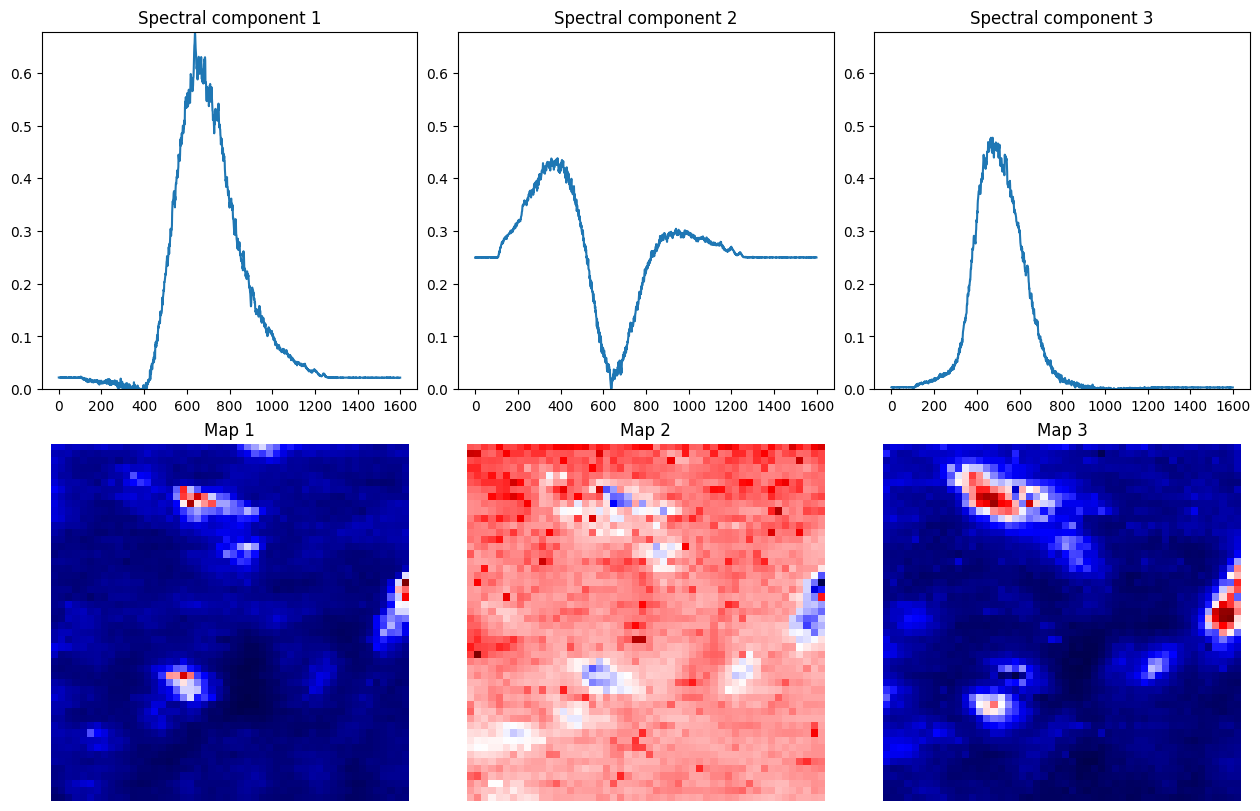

NUMBER OF COMPONENTS: 4


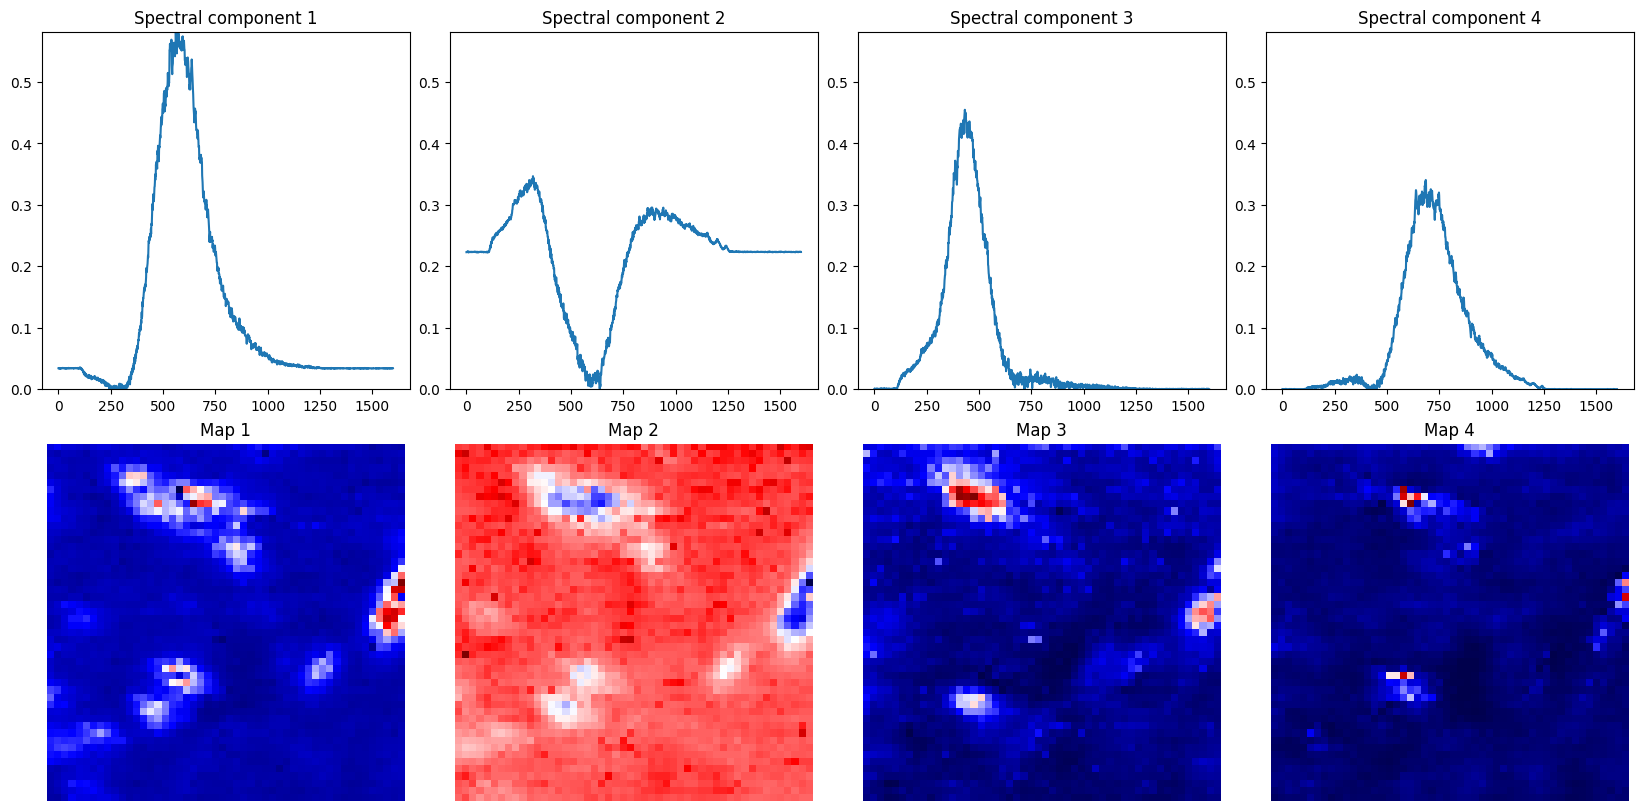

NUMBER OF COMPONENTS: 5


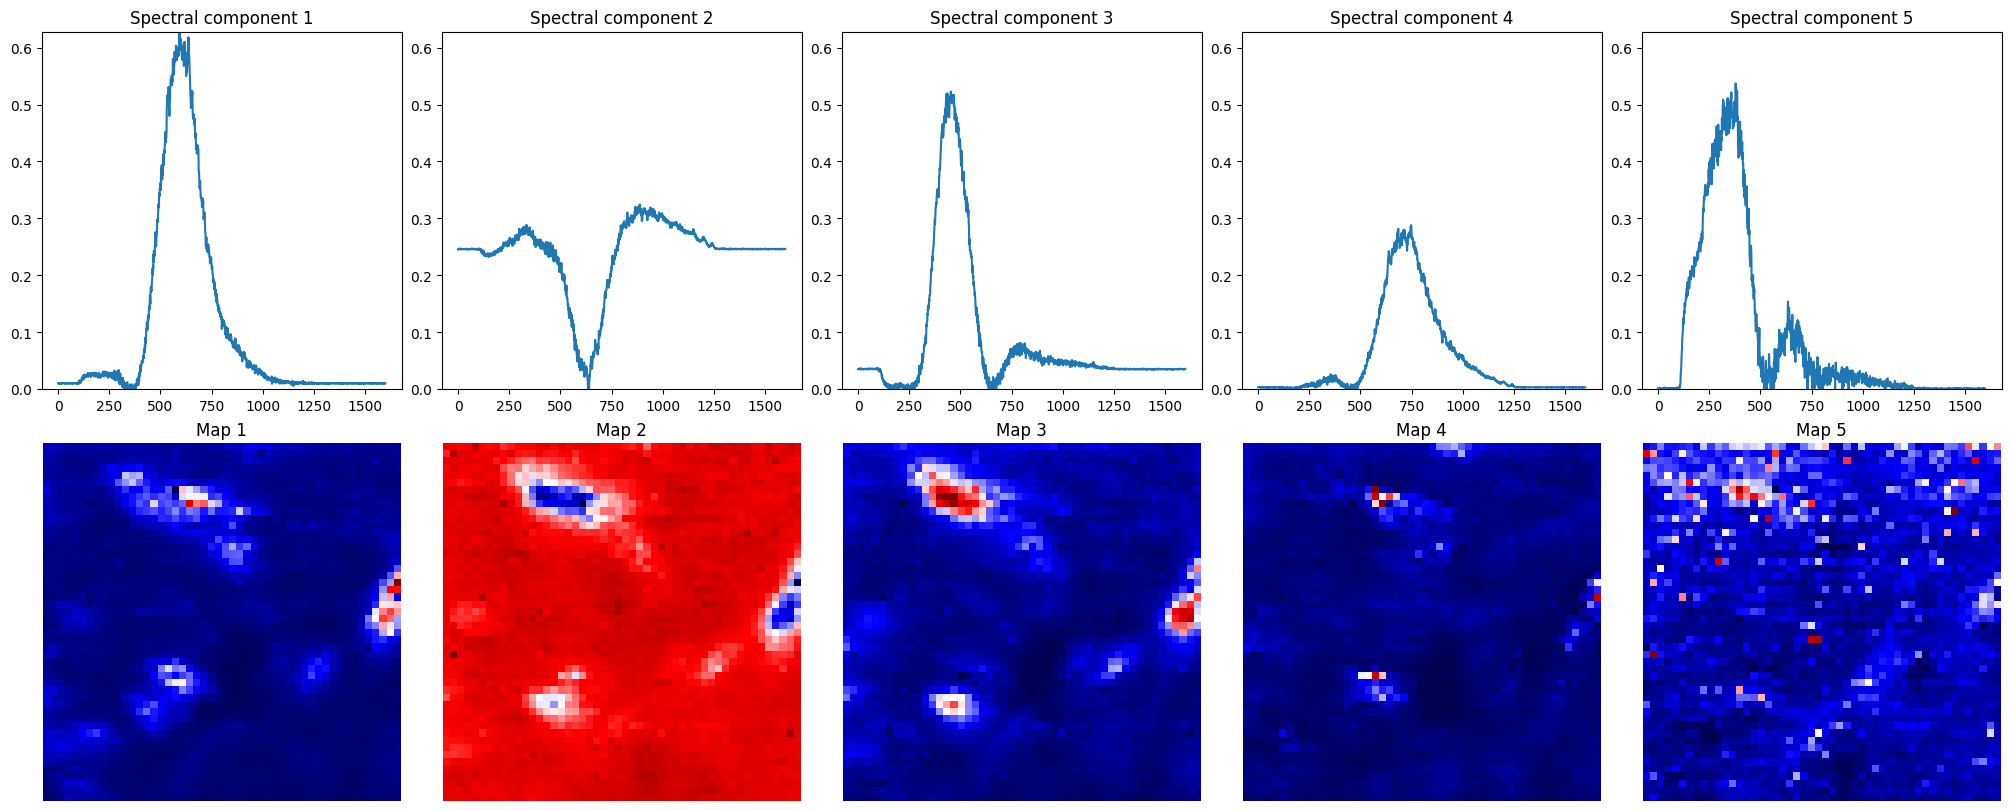

In [ ]:
n_components = [2, 3, 4, 5]

for n in n_components:
    print("NUMBER OF COMPONENTS: {}".format(n))
    dec = Decomposition(hdata1)
    maps, spectral_components = dec.nmf(n, random_state=1, sync_spectra_y_axis=True)

Let's plot NMF spectral components for a selected number of components:

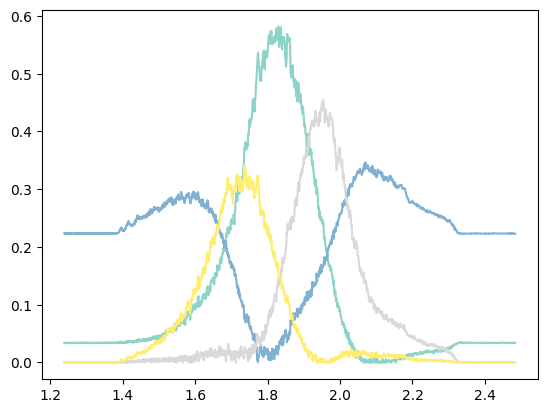

In [ ]:
maps, spectral_components = dec.nmf(4, random_state=1, plot_results=False)

colors = plt.cm.Set3(np.linspace(0, 1, len(spectral_components)))

for i, spectra in enumerate(spectral_components):
    plt.plot(energies, spectra, c=colors[i])